In [1]:
#!git clone https://huggingface.co/ctheodoris/Geneformer
#!pip install datasets
#!pip install transformers
#!pip install loompy
import os
GPU_NUMBER = [0]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(s) for s in GPU_NUMBER])
os.environ["NCCL_DEBUG"] = "INFO"
from collections import Counter
import datetime
import pickle
import subprocess
import seaborn as sns; sns.set()
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification
from transformers import BertModel
from transformers import Trainer
from transformers.training_args import TrainingArguments

from geneformer import DataCollatorForCellClassification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_dataset=load_from_disk("/content/drive/MyDrive/train.dataset")
test_dataset = load_from_disk("/content/drive/MyDrive/test.dataset")

print(train_dataset)
print(test_dataset)

Dataset({
    features: ['input_ids', 'cell_type', 'length'],
    num_rows: 60153
})
Dataset({
    features: ['input_ids', 'cell_type', 'length'],
    num_rows: 16653
})


In [3]:
dataset_list = []
evalset_list = []
organ_list = []
target_dict_list = []

trainset_organ_shuffled = train_dataset.shuffle(seed=42)
trainset_organ_shuffled = trainset_organ_shuffled.rename_column("cell_type","label")

testset_organ_shuffled = test_dataset.shuffle(seed=42)
testset_organ_shuffled = testset_organ_shuffled.rename_column("cell_type","label")



target_names = list(Counter(trainset_organ_shuffled["label"]).keys())
target_name_id_dict = dict(zip(target_names,[i for i in range(len(target_names))]))
target_dict_list += [target_name_id_dict]
print(target_dict_list)


def classes_to_ids(example):
    example["label"] = target_name_id_dict[example["label"]]
    return example
labeled_train_split = trainset_organ_shuffled.map(classes_to_ids, num_proc=1)
labeled_eval_split = testset_organ_shuffled.map(classes_to_ids, num_proc=1)



labeled_train_split = labeled_train_split.select([i for i in range(0, round(len(labeled_train_split)*0.1))])
labeled_eval_split = labeled_eval_split.select([i for i in range(0, round(len(labeled_eval_split)*0.1))])


trained_labels = list(Counter(labeled_train_split["label"]).keys())
def if_trained_label(example):
    return example["label"] in trained_labels
labeled_eval_split_subset = labeled_eval_split.filter(if_trained_label, num_proc=1)

dataset_list += [labeled_train_split]
evalset_list += [labeled_eval_split_subset]

[{'nasal mucosa goblet cell': 0, 'club cell': 1, 'respiratory basal cell': 2, 'respiratory hillock cell': 3, 'multi-ciliated epithelial cell': 4, 'ciliated columnar cell of tracheobronchial tree': 5, 'CD1c-positive myeloid dendritic cell': 6, 'bronchus fibroblast of lung': 7, 'CD8-positive, alpha-beta T cell': 8, 'mast cell': 9, 'B cell': 10, 'acinar cell': 11, 'plasmacytoid dendritic cell': 12, 'classical monocyte': 13, 'CD4-positive, alpha-beta T cell': 14, 'natural killer cell': 15, 'elicited macrophage': 16, 'ionocyte': 17, 'alveolar type 2 fibroblast cell': 18, 'alveolar macrophage': 19, 'dendritic cell': 20, 'brush cell of trachebronchial tree': 21, 'mucus secreting cell': 22, 'non-classical monocyte': 23, 'lung macrophage': 24, 'conventional dendritic cell': 25, 'tracheobronchial goblet cell': 26, 'vein endothelial cell': 27, 'tracheobronchial smooth muscle cell': 28, 'tracheobronchial serous cell': 29, 'bronchial goblet cell': 30, 'epithelial cell of lower respiratory tract': 3

In [ ]:
print(dataset_list[0][500])

{'input_ids': [20336, 17592, 11469, 4542, 8170, 12757, 5982, 13335, 7557, 4371, 2507, 8337, 6620, 17310, 17984, 9744, 7450, 14142, 11867, 8028, 2368, 3390, 9995, 10588, 14313, 12510, 2920, 7611, 355, 7544, 4702, 7114, 3964, 16137, 8584, 74, 861, 3076, 5657, 9957, 15056, 2976, 14091, 3756, 13647, 13288, 7140, 6286, 10201, 964, 7570, 9043, 13127, 5056, 16419, 1341, 11485, 2239, 1651, 1442, 4378, 10907, 11753, 1073, 12752, 2448, 5848, 13848, 6900, 3655, 5927, 10218, 13818, 8194, 6395, 14496, 12244, 5993, 1976, 10198, 332, 9260, 3313, 19666, 10449, 6144, 12261, 5023, 7026, 12492, 940, 10068, 8341, 17906, 3972, 2894, 7209, 8135, 4576, 20099, 6124, 3063, 7263, 4990, 4154, 3057, 4487, 3046, 3493, 13856, 1922, 15572, 2555, 4857, 1729, 4341, 2723, 1148, 12541, 5172, 5235, 745, 1802, 4732, 933, 1206, 3271, 17101, 6633, 1765, 12756, 14172, 936, 2919, 15587, 4251, 893, 18754, 1418, 10336, 17973, 8792, 520, 8288, 4533, 16378, 10800, 8939, 3092, 4557, 4516, 6037, 2638, 3603, 3990, 14744, 18830, 6625

In [4]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy and macro f1 using sklearn's function
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {
      'accuracy': acc,
      'macro_f1': macro_f1
    }

In [5]:
# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048

# set training parameters
# max learning rate
max_lr = 5e-4
# how many pretrained layers to freeze
freeze_layers = 0
# number gpus
num_gpus = 1
# number cpu cores
num_proc = 1
# batch size for training and eval
geneformer_batch_size = 12
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 500
# number of epochs
epochs = 5
# optimizer
optimizer = "adamw"

In [9]:
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
organ_trainset = dataset_list[0]
organ_evalset = evalset_list[0]
organ_label_dict = target_dict_list[0]


logging_steps = round(len(organ_trainset)/geneformer_batch_size/10)

model1 = BertForSequenceClassification.from_pretrained("model",
                                                    num_labels=len(organ_label_dict.keys()),
                                                    output_attentions = False,
                                                    output_hidden_states = False).to("cuda")

for param in model1.bert.parameters():
    param.requires_grad = False

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
output_dir = f"/path/to/models/{datestamp}_L{max_input_size}_B{geneformer_batch_size}_LR{max_lr}_LS{lr_schedule_fn}_WU{warmup_steps}_E{epochs}_O{optimizer}_F{freeze_layers}/"

saved_model_test = os.path.join(output_dir, f"pytorch_model.bin")
if os.path.isfile(saved_model_test) == True:
    raise Exception("Model already saved to this directory.")

subprocess.call(f'mkdir {output_dir}', shell=True)

training_args = {
    "learning_rate": max_lr,
    "do_train": True,
    "do_eval": True,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "logging_steps": logging_steps,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": epochs,
    "load_best_model_at_end": True,
    "output_dir": output_dir,
}

training_args_init = TrainingArguments(**training_args)

trainer = Trainer(
    model=model1,
    args=training_args_init,
    data_collator=DataCollatorForCellClassification(),
    train_dataset=organ_trainset,
    eval_dataset=organ_evalset,
    compute_metrics=compute_metrics
)

trainer.train()
predictions = trainer.predict(organ_evalset)


Some weights of the model checkpoint at model were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at model and are newly initialized: ['bert

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.403000,1.228334,0.541490,0.070959
2,1.033100,1.011088,0.738340,0.169636
3,0.948400,0.938033,0.746820,0.199742
4,0.887400,0.907795,0.754088,0.244912
5,0.887000,0.900851,0.752271,0.243680


/content/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/content/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/content/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/content/genefor

In [19]:
organ_trainset = dataset_list[0]
organ_evalset = evalset_list[0]
organ_label_dict = target_dict_list[0]

logging_steps = round(len(organ_trainset)/geneformer_batch_size/10)

model2 = BertForSequenceClassification.from_pretrained("model",
                                                    num_labels=len(organ_label_dict.keys()),
                                                    output_attentions = False,
                                                    output_hidden_states = False).to("cuda")

training_args2 = {
    "learning_rate": max_lr,
    "do_train": True,
    "do_eval": True,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "logging_steps": logging_steps,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": 1,
    "load_best_model_at_end": True,
    "output_dir": ".",
}

training_args_init2 = TrainingArguments(**training_args2)

trainer = Trainer(
    model=model2,
    args=training_args_init2,
    data_collator=DataCollatorForCellClassification(),
    train_dataset=organ_trainset,
    eval_dataset=organ_evalset,
    compute_metrics=compute_metrics
)

trainer.train()

for param in model2.bert.parameters():
    param.requires_grad = False

training_args = {
    "learning_rate": max_lr,
    "do_train": True,
    "do_eval": True,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "logging_steps": logging_steps,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": epochs,
    "load_best_model_at_end": True,
    "output_dir": ".",
}

training_args_init = TrainingArguments(**training_args)

trainer = Trainer(
    model=model2,
    args=training_args_init,
    data_collator=DataCollatorForCellClassification(),
    train_dataset=organ_trainset,
    eval_dataset=organ_evalset,
    compute_metrics=compute_metrics
)
    # train the cell type classifier
trainer.train()
predictions = trainer.predict(organ_evalset)

Some weights of the model checkpoint at model were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at model and are newly initialized: ['bert

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.741200,1.016451,0.651121,0.215070


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/content/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.518800,0.685883,0.773471,0.285080
2,0.404800,0.658579,0.802544,0.365309
3,0.354900,0.655254,0.814658,0.378261
4,0.409800,0.672056,0.811629,0.419316
5,0.388000,0.669140,0.812235,0.377559


/content/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/content/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/content/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/content/genefor

In [20]:
trainer.save_model("new_model")

In [21]:
import torch
from geneformer import DataCollatorForGeneClassification
class DataCollatorForCellClassification(DataCollatorForGeneClassification):

    class_type = "cell"

    def _prepare_batch(self, features):

        batch = super()._prepare_batch(features)

        # Special handling for labels.
        # Ensure that tensor is created with the correct type
        # (it should be automatically the case, but let's make sure of it.)
        first = features[0]
        if "label" in first and first["label"] is not None:
            label = first["label"].item() if isinstance(first["label"], torch.Tensor) else first["label"]
            dtype = torch.long if isinstance(label, int) else torch.float

        return batch

In [22]:
raw_model = BertModel.from_pretrained("new_model",
                                                    output_attentions = False,
                                                    output_hidden_states = False).to("cuda")

organ_trainset = dataset_list[0]
organ_evalset = evalset_list[0]
organ_label_dict = target_dict_list[0]

logging_steps = round(len(organ_trainset)/geneformer_batch_size/10)

training_args2 = {
    "learning_rate": max_lr,
    "do_train": True,
    "do_eval": True,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "logging_steps": logging_steps,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": 1,
    "load_best_model_at_end": True,
    "output_dir": ".",
}

training_args_init2 = TrainingArguments(**training_args2)


trainer = Trainer(
    model=raw_model,
    args=training_args_init2,
    data_collator=DataCollatorForCellClassification(),
    train_dataset=organ_trainset,
    eval_dataset=organ_evalset,
    compute_metrics=compute_metrics
)
embedding_test = trainer.predict(organ_evalset)


Some weights of the model checkpoint at new_model were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/content/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


In [23]:
import numpy as np

cell_embedding_train = np.zeros((len(organ_trainset), 256))

for i in range(len(organ_trainset)):
  cell_embedding_train[i] = np.mean(trainer.predict(organ_trainset.select([i for i in range(i, i+1)]))[0][0][0], axis = 0)

In [30]:
print(cell_embedding_train.shape)
print(cell_embedding_test.shape)

(6015, 256)
(1651, 256)


In [38]:
#!pip install anndata
#!pip install scanpy
#!pip install muon
from muon import atac as ac
import scanpy as sc
from geneformer import DataCollatorForCellClassification
import numpy as np
import pandas as pd
import anndata as ad

cell_embedding_test = np.zeros((embedding_test[0][0].shape[0], embedding_test[0][0].shape[2]))

for i, x in enumerate(embedding_test[0][0]):
  cell_embedding_test[i] = np.mean(x, axis = 0)

print(organ_trainset.select([i for i in range(0,1000)]))

target_dict_list_inv = {v: k for k, v in target_dict_list[0].items()}

cells_test = []
cells_train = []

for x in predictions[1]:
  cells_test.append(target_dict_list_inv[x])

for x in organ_trainset:
  cells_train.append(target_dict_list_inv[x["label"]])

adata_test = ad.AnnData(cell_embedding_test)
adata_train = ad.AnnData(cell_embedding_train)

adata_test.obs["pred_test_cell_type"] = cells_test

adata_train.obs["train_cell_type"] = cells_train




Dataset({
    features: ['input_ids', 'label', 'length'],
    num_rows: 1000
})


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


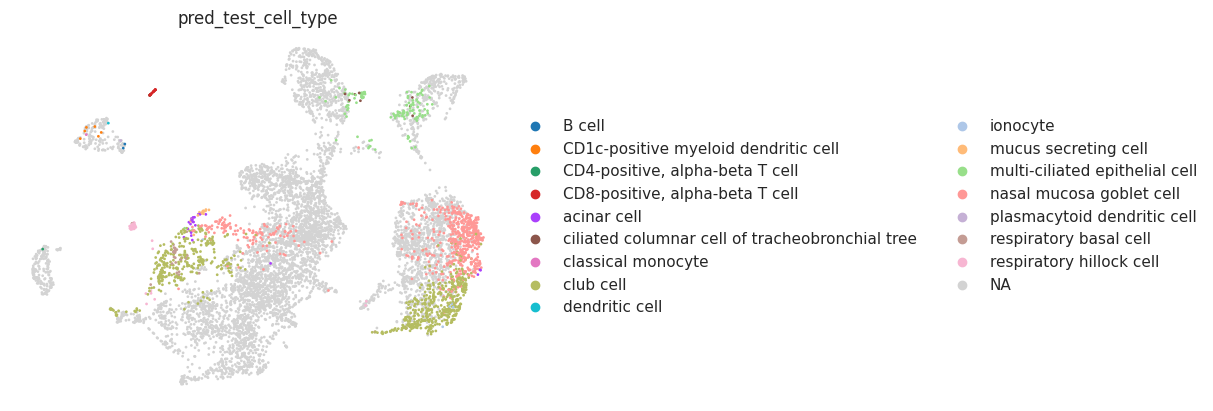

In [39]:
all = ad.AnnData(np.concatenate((cell_embedding_test, cell_embedding_train), axis = 0))

all.obs["pred_test_cell_type"] = cells_test + [np.nan] * cell_embedding_train.shape[0]

ac.tl.lsi(all)
sc.pp.neighbors(all, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(all, spread=1.5, min_dist=0.5, random_state=20)
sc.pl.umap(all, color = "pred_test_cell_type", wspace=0.5, frameon=False)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


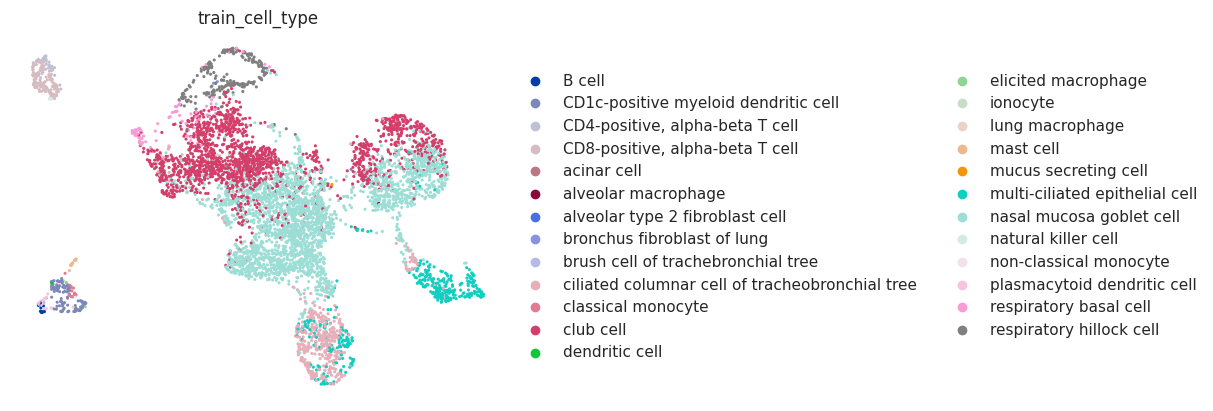

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


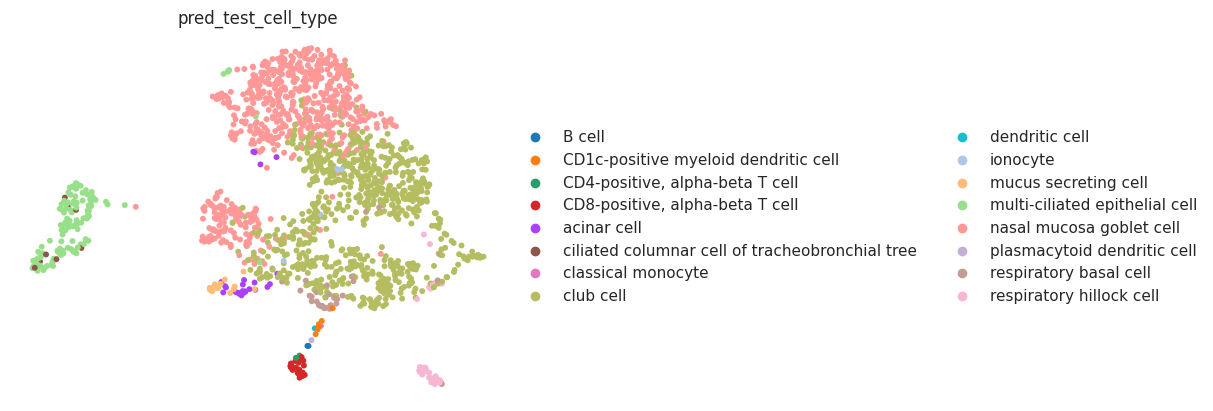

In [40]:
ac.tl.lsi(adata_train)
sc.pp.neighbors(adata_train, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_train, spread=1.5, min_dist=0.5, random_state=20)
sc.pl.umap(adata_train, color = "train_cell_type", wspace=0.5, frameon=False)

ac.tl.lsi(adata_test)
sc.pp.neighbors(adata_test, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_test, spread=1.5, min_dist=0.5, random_state=20)
sc.pl.umap(adata_test, color = "pred_test_cell_type", wspace=0.5, frameon=False)